In [1]:
import sys
print(sys.executable)
neural_struct_dir = '/mnt/g/PythonWorkspace/neural-structural-optimization/projects'
sys.path.insert(0, neural_struct_dir)
# hardcoded
cur_file_dir = '/mnt/g/PythonWorkspace/neural-structural-optimization/projects'

/home/shushu/install/anaconda3/bin/python


In [2]:
import matplotlib.pyplot as plt
import xarray
import tensorflow as tf
import time
import os
import pandas as pd

from neural_structural_optimization import problems
from neural_structural_optimization import topo_api
from neural_structural_optimization import train
from neural_structural_optimization.models import *

from cnn_sketch import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

2021-08-16 10:30:12.792666: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-16 10:30:12.792765: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/mnt/g/PythonWorkspace/neural-structural-optimization/neural_structural_optimization/autograd_lib.py:35: UserWarning: sksparse.cholmod not installed. Falling back to SciPy/SuperLU, but simulations will be about twice as slow.
  warnings.warn(


In [3]:
import sys
print(sys.executable)

/home/shushu/install/anaconda3/bin/python


In [4]:
def global_softmax(inputs):
    exp = tf.math.exp(inputs)
    s = tf.math.reduce_sum(exp)
    return exp/s

In [5]:
import pdb

In [6]:
class CNNSketch3(Model):

  def __init__(
      self,
      seed=0,
      args=None,
      latent_size = 128,
      dense_channels = 32,
      latent_scale=1.0,
      dense_init_scale=1.0,
      activation = tf.nn.tanh,
      volume_contraint = True,
      cone_filter = True
  ):
    super().__init__(seed, args, volume_contraint, cone_filter)

    activation = layers.Activation(activation)

    h = self.env.args['nely'] // 2
    w = self.env.args['nelx'] // 2
    
    net = inputs = layers.Input((latent_size,), batch_size=1)
    filters = h * w * dense_channels   # 32 * h/2 * w/2
    dense_initializer = tf.initializers.orthogonal(
        dense_init_scale * np.sqrt(max(filters / latent_size, 1)))
    net = layers.Dense(filters, kernel_initializer=dense_initializer)(net)
    net = layers.Reshape([h, w, dense_channels])(net)  

    net = activation(net)
    
    net = FlatConv3(net, 32, activation)  # 32 * h/2 * w/2

    net = UpConv4(net, 16, activation)  # 16 * h * w
    
    net = layers.Conv2D(1, 3, padding='same')(net)  # 1 * h * w
    # pdb.set_trace()
    net = global_softmax(net) 
    
    outputs = tf.squeeze(net, axis=[-1])

    self.core_model = tf.keras.Model(inputs=inputs, outputs=outputs)

    latent_initializer = tf.initializers.RandomNormal(stddev=latent_scale)
    self.z = self.add_weight(
        shape=inputs.shape, initializer=latent_initializer, name='z')

  def call(self, inputs=None):
    return self.core_model(self.z)

In [7]:
problem_mbb = problems.mbb_beam(width=64, height=32, density=0.5)
args_mbb = topo_api.specified_task(problem_mbb)
print(args_mbb)

{'young': 1, 'young_min': 1e-09, 'poisson': 0.3, 'g': 0, 'volfrac': 0.5, 'xmin': 0.001, 'xmax': 1.0, 'nelx': 64, 'nely': 32, 'mask': 1, 'freedofs': array([   1,    3,    5, ..., 4286, 4287, 4288]), 'fixdofs': array([   0,    2,    4,    6,    8,   10,   12,   14,   16,   18,   20,
         22,   24,   26,   28,   30,   32,   34,   36,   38,   40,   42,
         44,   46,   48,   50,   52,   54,   56,   58,   60,   62,   64,
       4289]), 'forces': array([ 0., -1.,  0., ...,  0.,  0.,  0.]), 'penal': 3.0, 'filter_width': 2}


In [8]:
cnns3_mbb = CNNSketch3(args=args_mbb, volume_contraint=True, cone_filter = True)
tic = time.perf_counter()
ds_cnns3_mbb = train.train_lbfgs(cnns3_mbb, 100)
toc = time.perf_counter()
print('Ellapsed time of training: %.2fs' % (toc-tic))

2021-08-16 10:30:34.991888: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-16 10:30:34.991974: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-16 10:30:34.992035: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-EOPHS13E): /proc/driver/nvidia/version does not exist
2021-08-16 10:30:34.992419: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Ellapsed time of training: 24.82s


In [9]:
ds_cnns3_mbb

<xarray.Dataset>
Dimensions:  (step: 74, y: 32, x: 64)
Coordinates:
  * step     (step) int64 0 1 2 3 4 5 6 7 8 9 ... 64 65 66 67 68 69 70 71 72 73
Dimensions without coordinates: y, x
Data variables:
    loss     (step) float64 393.7 393.3 393.0 388.6 ... 383.9 383.9 383.9 383.9
    design   (step, y, x) float64 0.4999 0.4999 0.5 0.5 ... 0.4999 0.5347 0.5912

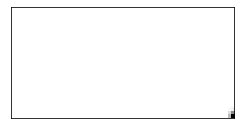

In [10]:
fig, ax = plt.subplots(figsize=(4, 3),subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(ds_cnns3_mbb.design.sel(step=73), cmap='Greys')

In [11]:
cnns3_mbb_no_conefilter = CNNSketch3(args=args_mbb, volume_contraint=True, cone_filter = False)
tic = time.perf_counter()
ds_cnns3_mbb_no_conefilter = train.train_lbfgs(cnns3_mbb_no_conefilter, 100)
toc = time.perf_counter()
print('Ellapsed time of training: %.2fs' % (toc-tic))

Ellapsed time of training: 34.38s


In [12]:
ds_cnns3_mbb_no_conefilter

<xarray.Dataset>
Dimensions:  (step: 107, y: 32, x: 64)
Coordinates:
  * step     (step) int64 0 1 2 3 4 5 6 7 8 ... 99 100 101 102 103 104 105 106
Dimensions without coordinates: y, x
Data variables:
    loss     (step) float64 393.7 393.0 391.1 390.6 ... 381.2 381.2 381.2 381.2
    design   (step, y, x) float64 0.4999 0.4999 0.5 0.5 ... 0.4999 0.5373 0.6007

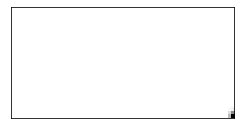

In [13]:
fig, ax = plt.subplots(figsize=(4, 3),subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(ds_cnns3_mbb.design.sel(step=73), cmap='Greys')